In [1]:
import cantata
from cantata.analysis.quantify import quantify_stimulated, quantify_unstimulated
import cantata.analysis.util as cantu
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cantata.plotting import output as cp
import pandas as pd
from timeit import timeit

In [2]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [3]:
%load_ext autoreload
%autoreload 2
%aimport -torch -np -plt -sns -pd

In [4]:
figsize = (14,5)

batch_size = 32
dt = 1e-3
device = torch.device('cuda')

periods = (int(100e-3/dt), int(100e-3/dt)) # ticks
rates = (0, 50) # Hz

settle, early, late = 0, (10,15), None # seconds

assert int(1/dt) % sum(periods) == 0

In [5]:
conf = cantata.config.read('/home/felix/projects/cantata/cantata/configs/1tier.yaml')
conf.pop('_prototypes')
print(conf.to_yaml())

input:
  n_channels: 1
  populations:
    Thal:
      n: 20
      channel: 0
      targets:
        L1:Exc:
          spatial: true
          density: 0.5
          delay: 0.001
          sigma: 0.5
          STDP_frac: 0.0
          A_p: 0.0
          A_d: 0.0
          wmin: 0.0
          wmax: 1.0
        L1:Inh:
          spatial: true
          density: 0.5
          delay: 0.001
          sigma: 0.5
          STDP_frac: 0.0
          A_p: 0.0
          A_d: 0.0
          wmin: 0.0
          wmax: 1.0
      sign: 1
areas:
  L1:
    populations:
      Exc:
        sign: 1
        n: 200
        p: -0.1
        noise_N: 2000
        noise_rate: 8.0
        noise_weight: 0.002
        th_ampl: 0.05
        targets:
          Exc:
            spatial: true
            density: 0.5
            delay: 0.001
            STDP_frac: 1.0
            A_p: 0.2
            A_d: 0.2
            sigma: 0.5
            wmin: 0.0
            wmax: 1.0
          Inh:
            spatial: true
     

In [6]:
# def connectivity(conf, m):
#     area_connectivity(conf.input, m.input)
#     for 

SyntaxError: invalid syntax (<ipython-input-6-486679df6cd3>, line 3)

In [7]:
def run(m):
    with torch.no_grad():
        unstim, _ = quantify_unstimulated(m, dt, early=early, late=late)
        stim, _ = quantify_stimulated(
            m, periods, rates, dt, settle=settle, early=early, late=late)
    return unstim, stim

In [8]:
def raster(m, unstim, stim, batch = 0, kwidth=10):
    Xu = torch.cat(unstim['X'], dim=2)
    Xs = torch.cat(stim['X'], dim=2)
    Ru = cp.get_rates(Xu, m, batch_size, dt, kwidth=kwidth)
    Rs = cp.get_rates(Xs, m, batch_size, dt, kwidth=kwidth)
    cp.raster(Xu, m, rates=Ru, batch=batch)
    ax = cp.raster(Xs, m, rates=Rs, batch=batch)
    
    period = sum(periods)
    ticks = int((early[1] - early[0])/dt)
    onsets = np.arange(ticks/period) * period
    for o in onsets:
        ax.axvspan(o, o + periods[0], fc='gray', alpha=0.1)

In [9]:
def pretty(d, indent=0, tab = '  ', exclude = []):
    for key, value in d.items():
        if key in exclude:
            continue
        keystr = tab * indent + str(key) + ':'
        if isinstance(value, dict):
            print(keystr)
            pretty(value, indent+1, tab=tab, exclude=exclude)
        else:
            if isinstance(value, torch.Tensor) and value.shape == torch.Size([]):
                print(f'{keystr}\t{value.item():.4f}')
            else:
                print(keystr)
                print(tab * (indent+1) + str(value))

In [10]:
def quantiles(unstim, stim):
    q = np.arange(11)*10
    plt.subplots(2,3, figsize=(14,8), sharex = 'col')
    
    for i,key in enumerate(stim['rates'].keys()):
        ax = plt.subplot(2,3,1+i)
        plt.title(f'{key} rate')
        if i==0:
            plt.ylabel('Quantile (unstimulated)')
        plt.plot(unstim['rates'][key]['quantiles'], q)
        
        plt.subplot(2,3,4+i, sharex = ax)
        if i==0:
            plt.ylabel('Quantile (stimulated)')
        plt.xlabel('Rate (Hz)')
        plt.plot(stim['rates'][key]['quantiles'], q)
        for i in range(len(periods)):
            plt.plot(stim['pulses'][key]['quantiles'][i], q)
        locs, labels = plt.yticks()
        plt.gca().set_prop_cycle(None)
        plt.errorbar(stim['rates'][key]['mean'], -10, xerr = stim['rates'][key]['std'], fmt='o')
        locs = [j for j in q if j%20 == 0]
        labels = [str(j) for j in q if j%20 == 0]
        locs.append(-10)
        labels.append('Overall')
        for i,level in enumerate(rates):
            y = -10*(i+2)
            plt.errorbar(stim['pulses'][key]['mean'][i], y, xerr = stim['pulses'][key]['std'][i], fmt='o')
            locs.append(y)
            labels.append(f'{level} Hz')
        plt.yticks(locs, labels)
    
    plt.subplot(233)
    plt.title('Exc->Exc weights')
    plt.plot(unstim['weights']['quantiles'], q)
    
    plt.subplot(236)
    plt.xlabel('Weight')
    plt.plot(stim['weights']['quantiles'], q)

In [11]:
m = cantata.Conductor(conf, batch_size, dt, shared_weights = False).to(device)
unstim, stim = run(m)

Unstimulated:
    weights:
        mobility_mean:	0.9709
        mobility_std:	0.0164
        mean:	0.2768
        std:	0.2937
        lo:	0.2149
        hi:	0.0111
    rates:
        Exc:
            mean:	4.9349
            std:	0.6819
            burst_mean:	24.3934
            burst_std:	5.6614
        Inh:
            mean:	11.3941
            std:	3.2998
            burst_mean:	42.6869
            burst_std:	3.1733
Stimulated:
    weights:
        mobility_mean:	0.9930
        mobility_std:	0.0034
        mean:	0.2340
        std:	0.3138
        lo:	0.2046
        hi:	0.0252
    rates:
        Exc:
            mean:	7.4921
            std:	0.9902
            burst_mean:	18.5458
            burst_std:	5.0915
        Inh:
            mean:	23.5218
            std:	3.5599
            burst_mean:	43.0238
            burst_std:	2.8984
    pulses:
        Exc:
            pulse_sensitive:
                tensor([0.0370, 0.6027])
            onset_sensitive:
                tensor([0.25

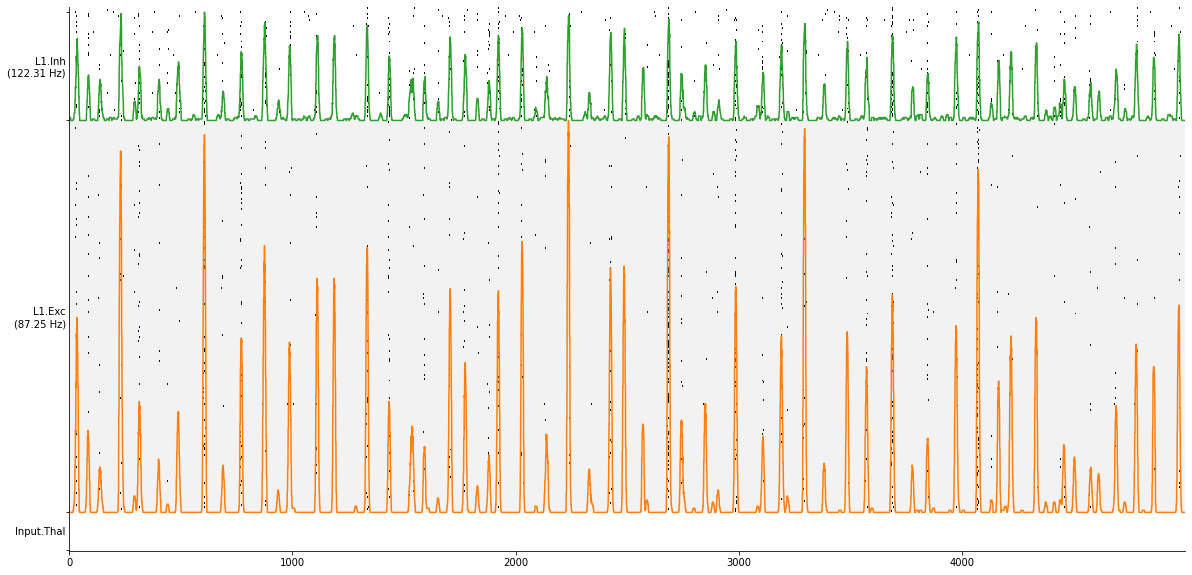

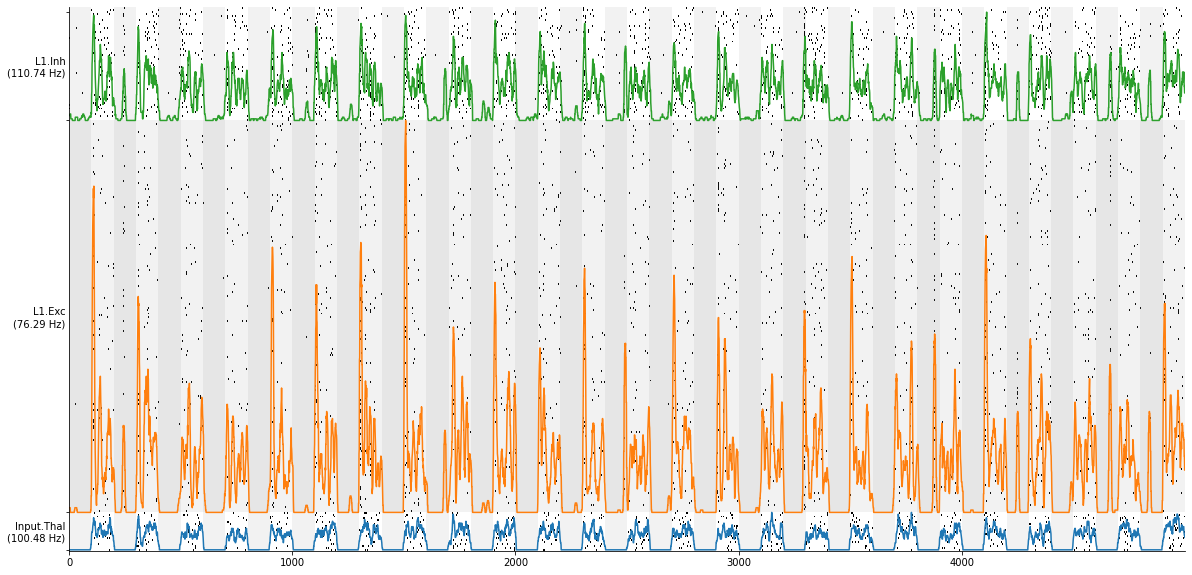

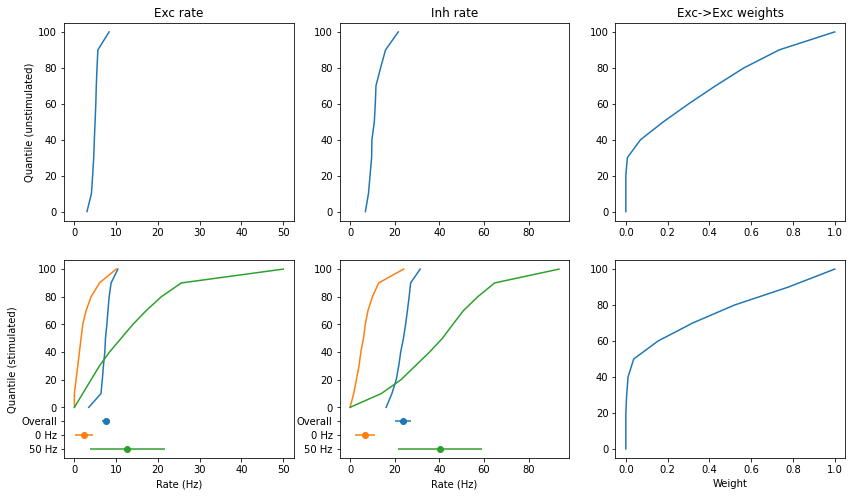

In [12]:
pretty({'Unstimulated': unstim, 'Stimulated': stim}, exclude = ['X', 'quantiles'], tab='    ')
raster(m, unstim, stim, kwidth=10)
quantiles(unstim, stim)

In [13]:
iconf = conf.copy()
iconf.areas.L1.populations.Inh.noise_weight = 4e-3

m = cantata.Conductor(iconf, batch_size, dt, shared_weights = False).to(device)
unstim, stim = run(m)

Unstimulated:
    weights:
        mobility_mean:	0.9884
        mobility_std:	0.0073
        mean:	0.3262
        std:	0.2925
        lo:	0.1378
        hi:	0.0049
    rates:
        Exc:
            mean:	3.4406
            std:	0.6640
            burst_mean:	15.6622
            burst_std:	3.4002
        Inh:
            mean:	16.4156
            std:	8.4008
            burst_mean:	34.8652
            burst_std:	3.6328
Stimulated:
    weights:
        mobility_mean:	0.9953
        mobility_std:	0.0009
        mean:	0.2834
        std:	0.3131
        lo:	0.1400
        hi:	0.0154
    rates:
        Exc:
            mean:	7.0764
            std:	1.0806
            burst_mean:	13.9599
            burst_std:	1.0999
        Inh:
            mean:	29.2988
            std:	6.1362
            burst_mean:	40.3422
            burst_std:	1.1473
    pulses:
        Exc:
            pulse_sensitive:
                tensor([0.0044, 0.7120])
            onset_sensitive:
                tensor([0.05

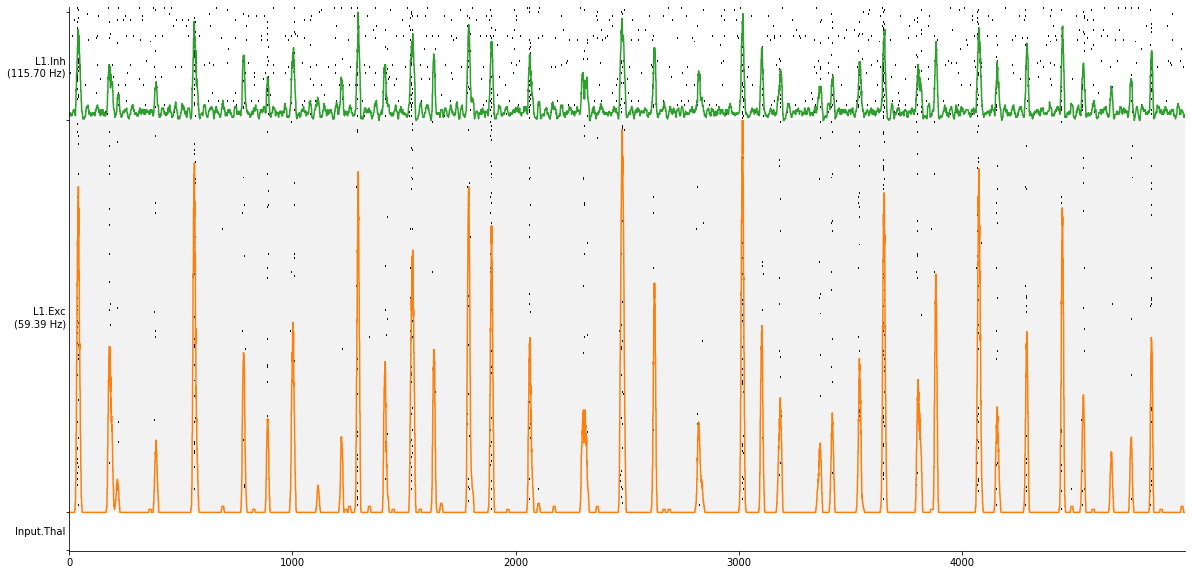

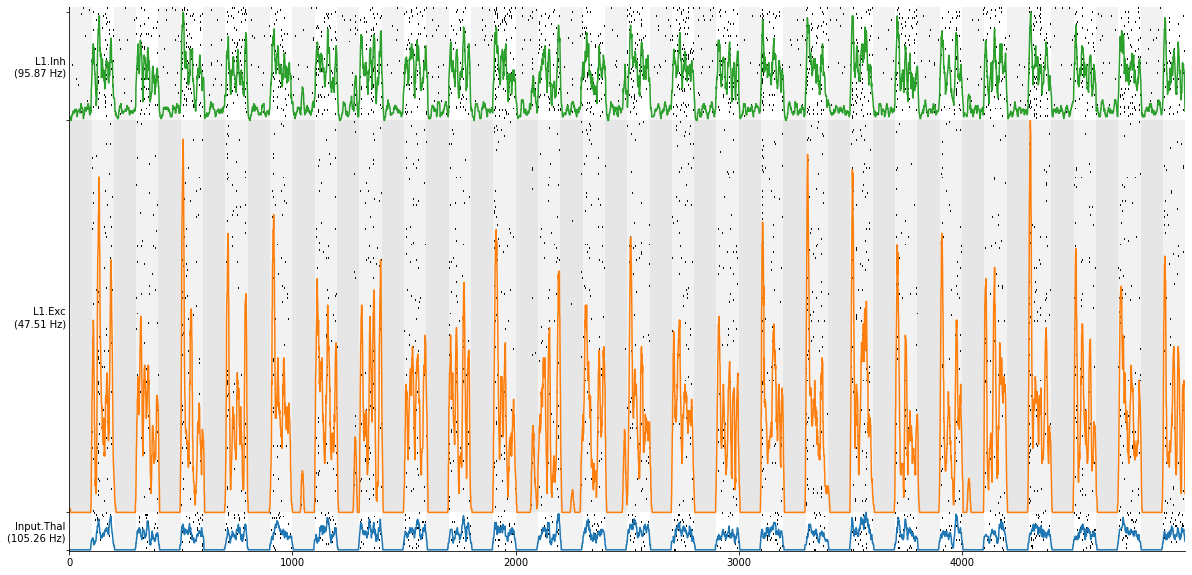

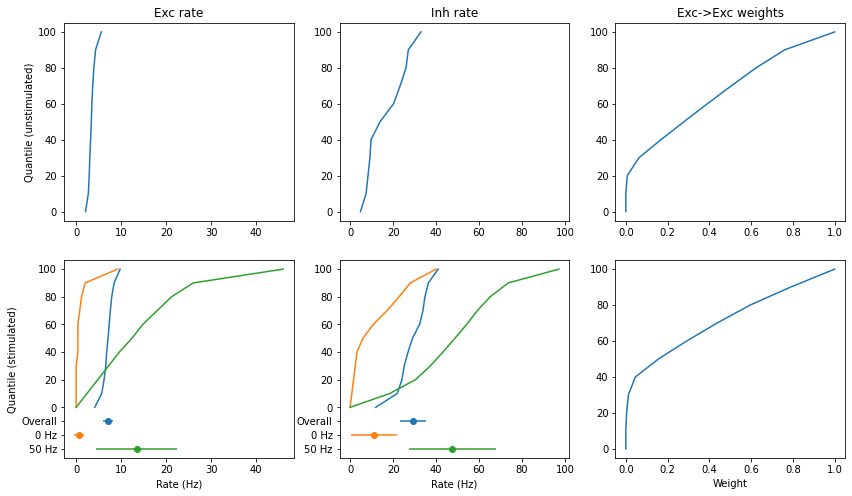

In [14]:
pretty({'Unstimulated': unstim, 'Stimulated': stim}, exclude = ['X', 'quantiles'], tab='    ')
raster(m, unstim, stim, kwidth=10)
quantiles(unstim, stim)

In [15]:
iconf = conf.copy()
iconf.areas.L1.populations.Inh.noise_weight = 4e-3
iconf.input.populations.Thal.targets['L1:Exc'].min_weight = 0.5
iconf.input.populations.Thal.targets['L1:Inh'].min_weight = 0.5

m = cantata.Conductor(iconf, batch_size, dt, shared_weights = False).to(device)
unstim, stim = run(m)

Unstimulated:
    weights:
        mobility_mean:	0.9930
        mobility_std:	0.0047
        mean:	0.3323
        std:	0.2909
        lo:	0.1247
        hi:	0.0036
    rates:
        Exc:
            mean:	3.0374
            std:	0.6765
            burst_mean:	12.9726
            burst_std:	2.8261
        Inh:
            mean:	16.7254
            std:	8.7979
            burst_mean:	32.2462
            burst_std:	3.3170
Stimulated:
    weights:
        mobility_mean:	0.9954
        mobility_std:	0.0006
        mean:	0.2899
        std:	0.3094
        lo:	0.1233
        hi:	0.0120
    rates:
        Exc:
            mean:	7.0052
            std:	1.0172
            burst_mean:	13.3614
            burst_std:	0.8292
        Inh:
            mean:	29.8817
            std:	7.0337
            burst_mean:	39.8171
            burst_std:	1.1166
    pulses:
        Exc:
            pulse_sensitive:
                tensor([0.0022, 0.7112])
            onset_sensitive:
                tensor([0.04

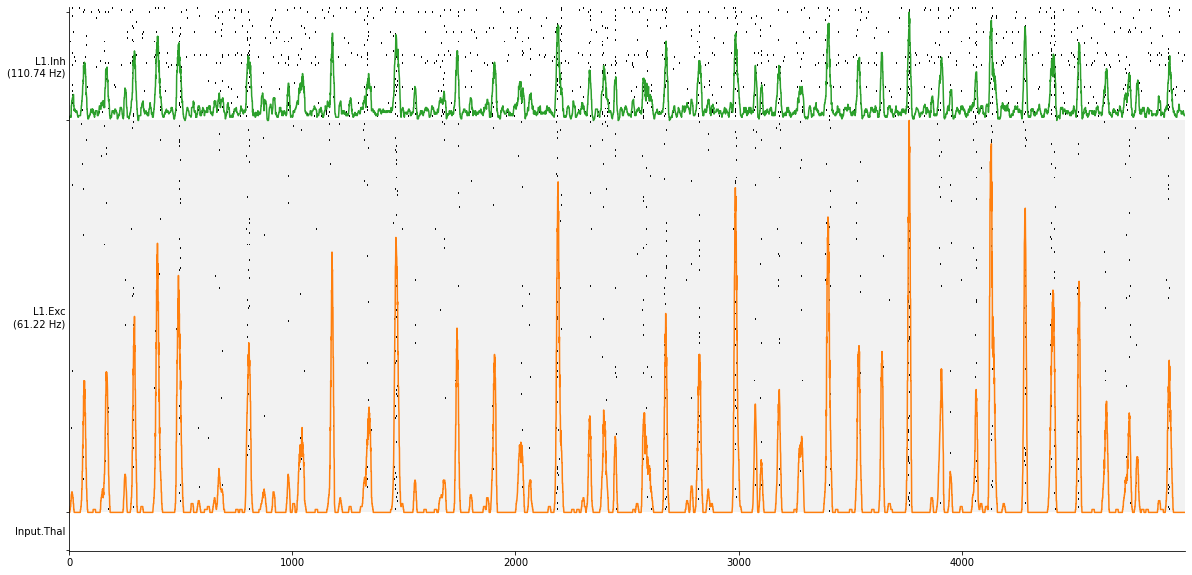

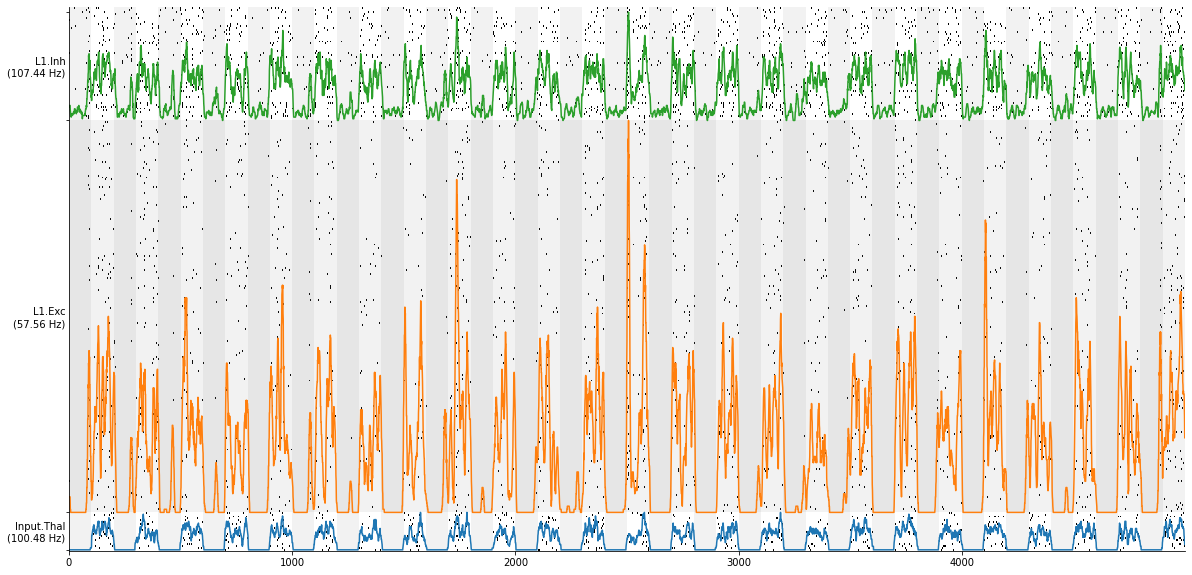

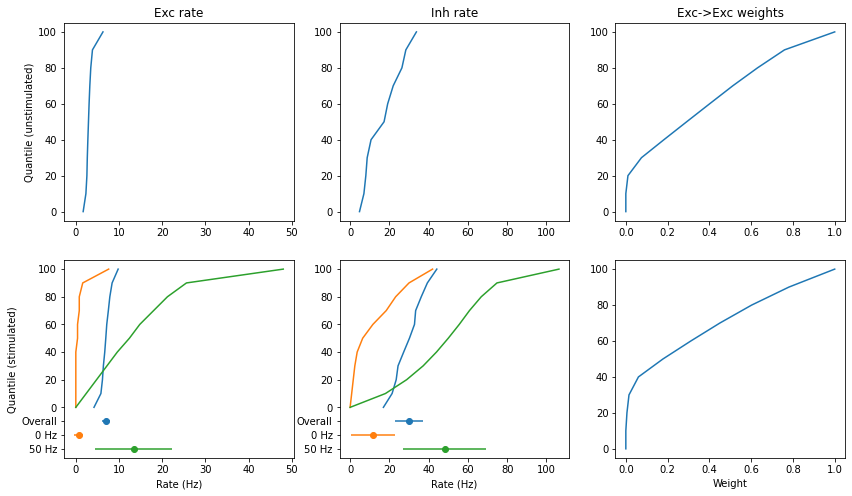

In [16]:
pretty({'Unstimulated': unstim, 'Stimulated': stim}, exclude = ['X', 'quantiles'], tab='    ')
raster(m, unstim, stim, kwidth=10)
quantiles(unstim, stim)